# Examining Model Performance

In this notebokk you will learn how to:

* Get number of images and classes
* Load a saved model
* Preprocesses data for predictions
* Make predictions
* Generate a Classification Report
* Generate a Confusion Matrix

In [1]:
# Needed to load model (you can also load from json)
from tensorflow.keras.models import load_model, model_from_json
# Needed for Confusion Matrix and classification report
from sklearn.metrics import classification_report, confusion_matrix
# We need to preprocess our test images
from tensorflow.keras.applications.resnet50 import preprocess_input

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

## Get number of images and classes

We can get the number of images and classes from our data generator objects

In [2]:
# We are only doing this to get the number of images and classes from the generator objects
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator = train_datagen.flow_from_directory('data/train')
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator = train_datagen.flow_from_directory('data/val', shuffle=False)

Found 12894 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


### Here are the number of images from the generators

In [3]:
train_generator.n, validation_generator.n

(12894, 500)

### We can get the labels from the generator as well

In [4]:
labels = (validation_generator.class_indices); labels

{'cassette_player': 0,
 'chain_saw': 1,
 'church': 2,
 'english_springer': 3,
 'french_horn': 4,
 'garbage_truck': 5,
 'gas_pump': 6,
 'golf_ball': 7,
 'parachute': 8,
 'tench': 9}

## Load the model

Now that we have some information about the structure of our data we can load one of our previous models

In [5]:
model = load_model("models/ResNet50_Transfer_model.h5")

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Preprocess data for predections

The required steps are as follows:

* Choose some images for inference
* Load the data from the path
* Preprocess the data

### Choose a few images

In [6]:
validation_images_paths = [
    'data/val/cassette_player/ILSVRC2012_val_00000557.JPEG',
    'data/val/english_springer/ILSVRC2012_val_00000665.JPEG',
    'data/val/parachute/ILSVRC2012_val_00001440.JPEG'
]

### Load data from the paths

Here we will use PIL (Python Image Library) to get the image objects from the paths

In [7]:
image_list = [Image.open(image_path) for image_path in validation_images_paths];
image_list

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=160x213 at 0x7F9B8F2F2490>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=239x160 at 0x7F9B8FC224D0>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=213x160 at 0x7F9AD041FA90>]

### Preprocess the data 

* Notice the size attribute for the images
* Remember we trained our model on images with heightxwidth = 224x224
* Sor foe or preprocessing step will will resize the images and cast them to numpy arrays
* The resulting shape will be (# of images, height, width, channels)

In [8]:
image_size = (224, 224)
validation_batch = np.stack([preprocess_input(np.array(img.resize(image_size))) for img in image_list])
validation_batch.shape

(3, 224, 224, 3)

## Making Predictions

We can now run the predict function on our image batch

This is **the most important thing you will learn** after training the model

In [9]:
pred_probs = model.predict_on_batch(validation_batch)

We can take the argmax across the columns to find the predictions for each input image

In [10]:
np.argmax(pred_probs, axis=1)

array([0, 3, 8])

As a reminder here are all of our labels

If your model performs well you should see that the numbers above match the expected class

In [11]:
labels

{'cassette_player': 0,
 'chain_saw': 1,
 'church': 2,
 'english_springer': 3,
 'french_horn': 4,
 'garbage_truck': 5,
 'gas_pump': 6,
 'golf_ball': 7,
 'parachute': 8,
 'tench': 9}

Now we will visualize our results

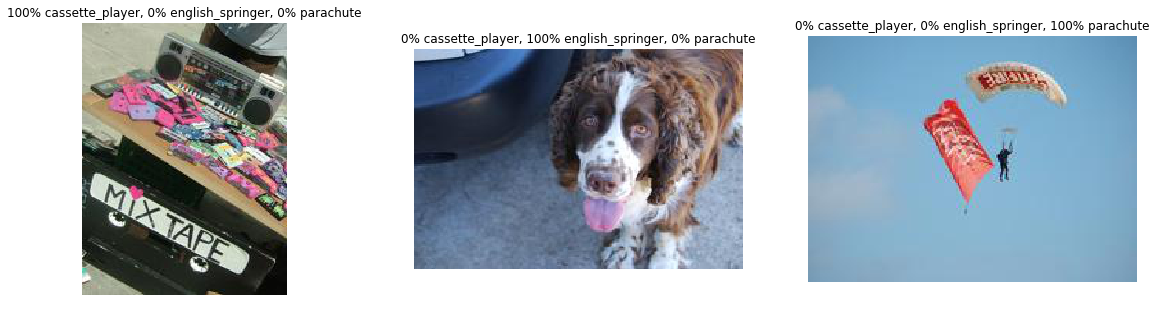

In [12]:
fig, axs = plt.subplots(1, len(image_list), figsize=(20, 5))

for i, img in enumerate(image_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title(f"{100*pred_probs[i,0]:.0f}% cassette_player, {100*pred_probs[i,3]:.0f}% english_springer, {100*pred_probs[i,8]:.0f}% parachute")
    ax.imshow(img)

## Confusion Matrix

A confusion matrix is a great representation of what your model os getting mixed up 

You should observe a strong diagonal if your model performs well

You can read the confusion matrix as follows:

* The left side is what the model predicted
* The bottom is what the actual class was
* So look at the left column and say: "The model predicted $x$ and" then look at the bottom and say: "And the actual value was $y$"

Side Note:

You may want to increase the figsize if you trained on many class

In [13]:
import seaborn as sns
num_of_test_samples = validation_generator.n
batch_size = train_generator.batch_size
Y_pred = model.predict_generator(validation_generator)
y_pred = np.argmax(Y_pred, axis=1)

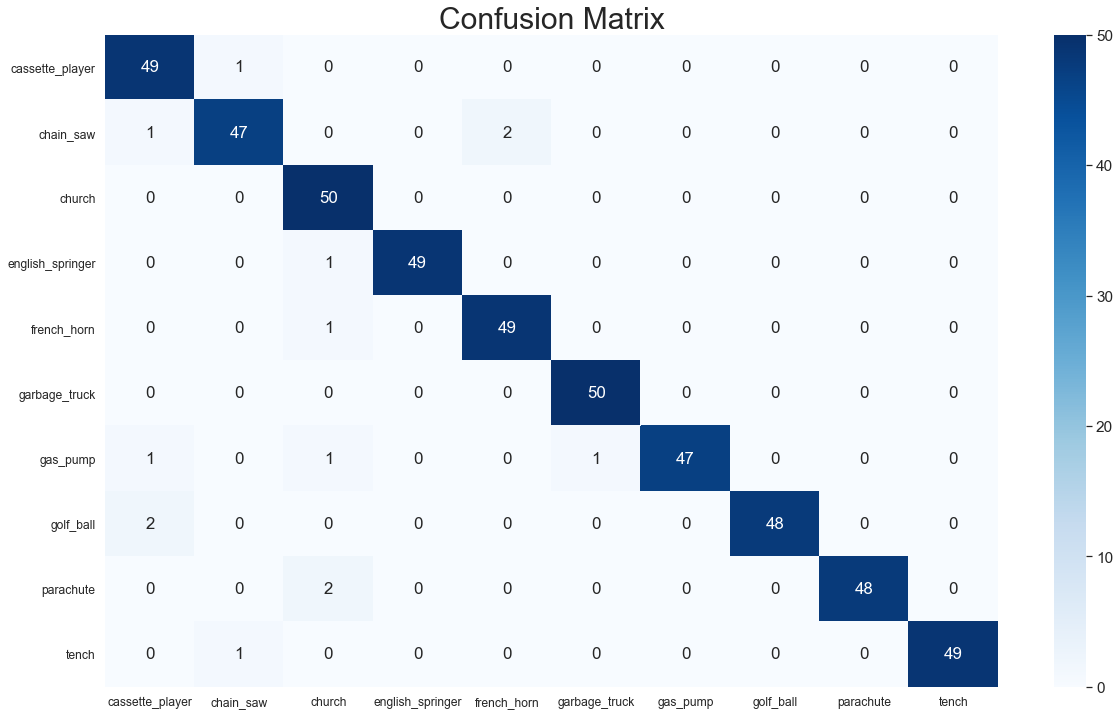

In [15]:
plt.subplots(figsize=(20,12))
plt.title("Confusion Matrix", fontsize=30)
sns.set(font_scale=1.4)
sns.heatmap(confusion_matrix(validation_generator.classes, y_pred), annot=True, fmt='.10g', cmap='Blues', yticklabels=labels, xticklabels=labels)
plt.yticks(rotation=0);

## Classification Report 

The reported averages include:

* precision